In [2]:
%matplotlib inline
%load_ext rpy2.ipython
import os

GIMME_DIR = "/home/isaac/gimmeSAD"
#SIMOUT_DIR = os.path.join(GIMME_DIR, "1d_sims/")
SIMOUT_DIR = GIMME_DIR + "/1d_sims/"
OBSERVED_FILE = os.path.join(GIMME_DIR, "empirical_data/spider.obs")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import subprocess

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Gather all the simulations into one huge simout file

In [127]:
REF_TABLE = os.path.join(SIMOUT_DIR, "spider-priors.txt")
outfile = open(REF_TABLE, "w")

ONEPER = False
REGULARIZE = True
DROPEQUILIBSIMS = False

files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
numsims = 0
outfile.write(open(files[0]).readlines()[0])
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## DO or don't regularlize the histograms
            if REGULARIZE:
                hist = np.array([int(x) for x in line.split()[7:]])
                if np.sum(hist):
                    tot = np.sum(hist)
                    hist = hist/float(tot)
                tmp = line.split()[:7] + map(str,hist)
                line = "\t".join(tmp) + "\n"
                new_lines.append(line)

            ## Do or don't drop all the extra sims at equilibrium
            if line.split()[3] == "1" and DROPEQUILIBSIMS:
                pass
            else:
                new_lines.append(line)
        except:
            pass
    lines = new_lines
    ## Only choose one step per simulation?
    if lines and ONEPER:
        lines = [random.choice(lines).strip()]

    ## Don't write blanks
    if lines:
        numsims += len(lines)
        lines[-1] = lines[-1].strip()
        outfile.write("".join(lines))
        outfile.write("\n")
outfile.close()

print("Processed {} simulations.".format(numsims))

Processed 6204616 simulations.


6204616
6204616
('min bin size ', 399710)


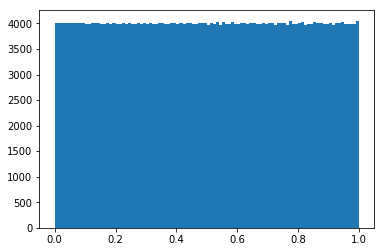

In [84]:
REF_TABLE = os.path.join(SIMOUT_DIR, "spider-priors.txt")
dat = pd.read_csv(REF_TABLE, sep="\t")
## Duplicate rows mess up the ABC
print(len(dat))
#dat.drop_duplicates(subset=["shannon", "bin_0", "bin_1", "bin_2", "bin_3", "bin_4",\
#                                        "bin_5", "bin_6", "bin_7", "bin_8", "bin_9"], inplace=True)
print(len(dat))
## scale everything to the smallest presumed bin
minct = np.count_nonzero(dat["%equil"] < 0.01)
print("min bin size ", minct)
## Truncate to a smaller number of sims
minct = 4000

gt_val = 0.01
outdf = dat[dat['%equil'] < gt_val].sample(n=minct, replace=False)
for lt_val in np.arange(0.02, 1.01, .01):
    gt = dat["%equil"] > gt_val
    lt = dat["%equil"] < lt_val
    gt_val = lt_val
    try:
        samps = dat[lt & gt]
        ## Watch this, it'll bite you with the replacement.
        tmpdf = samps.sample(n=minct, replace=False)
    except:
        print(lt_val, len(samps))
    outdf = pd.concat([outdf, tmpdf])
#outdf
_, _, _ = plt.hist(outdf["%equil"], bins=100)
outdf.to_csv(REF_TABLE, sep="\t", index=False)

## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

## Load the data into R

In [85]:
%%R -i OBSERVED_FILE -i REF_TABLE
library(abc)

OBS<- read.table(OBSERVED_FILE, header=TRUE)

## fill adds NA for any incomplete row
PRIOR <- read.table(REF_TABLE, header=TRUE, fill=TRUE)
print(PRIOR[1,])
print(OBS)

     K           c    step     X.equil      colrate     extrate shannon bin_0
1 3549 0.000122938 1390000 0.002817695 0.0001309353 0.000128777  1.0889     1
  bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1     0     0     0     0     0     0     0     0     0
   shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
1 2.246206     8    25     7     4     1     3     2     4     1     2


In [86]:
%%R
## Do or don't regularize the observed pi bins
if(FALSE){
    shan = OBS[1]
    tot = sum(OBS[2:11])
    OBS = data.frame(c(shan, OBS[2:11]/tot))
    print(OBS)
}

   shannon     bin_0     bin_1    bin_2      bin_3      bin_4      bin_5
1 2.246206 0.1403509 0.4385965 0.122807 0.07017544 0.01754386 0.05263158
       bin_6      bin_7      bin_8      bin_9
1 0.03508772 0.07017544 0.01754386 0.03508772


## Estimate % equilibrium using shannon index and 1d pi vector


### Rejection

Prediction error based on a cross-validation sample of 25

             eq
0.001 0.3146644
0.005 0.3323106
0.01  0.3451758


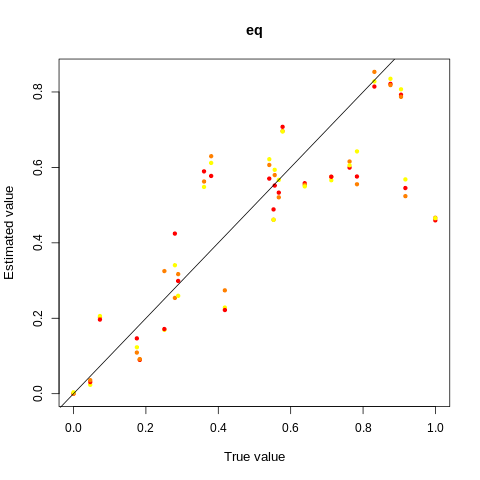

In [184]:
%%R
cv.res.rej <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=25, tols=c(0.001,.005,.01), method="rejection")
print(summary(cv.res.rej))
plot(cv.res.rej)

### Loclinear regression

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.5547713
0.005 0.5266061
0.01  0.5135752


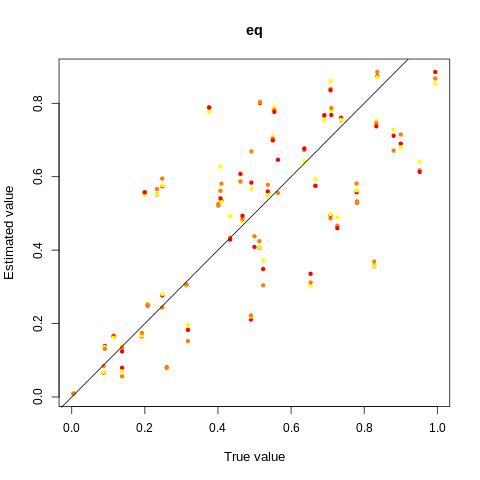

In [185]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Results with pi vectors regularized to sum to 1

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=100, tols=c(.005, .01, .05), method="loclinear")
#cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7:17], nval=50, tols=.005, method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

## Do the ABC

In [5]:
%%R
resboth.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7:17], tol=0.0025,
                  hcorr=FALSE, method="rejection", lambda=1, numnet=5, sizenet=30)
print(summary(resboth.abc))
hist(resboth.abc)
plot(resboth.abc, param=PRIOR[,"X.equil"])


Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7:17], tol = 0.0025, method = "rejection", 
    hcorr = FALSE, numnet = 5, sizenet = 30, lambda = 1)
Data:
 abc.out$unadj.values (1000 posterior samples)

                 eq
Min.:        0.4767
2.5% Perc.:  0.6392
Median:      0.9221
Mean:        0.8972
Mode:        0.9700
97.5% Perc.: 0.9969
Max.:        0.9999
                    eq
Min.:        0.4767123
2.5% Perc.:  0.6392367
Median:      0.9221174
Mean:        0.8971705
Mode:        0.9700085
97.5% Perc.: 0.9968686
Max.:        0.9998835
Error in plot.abc(resboth.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE


/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in plot.abc(resboth.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In read.table(OBSERVED_FILE, header = TRUE) :
  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
 
  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init

0.8971704893579291
[0.6962624 0.9998835]


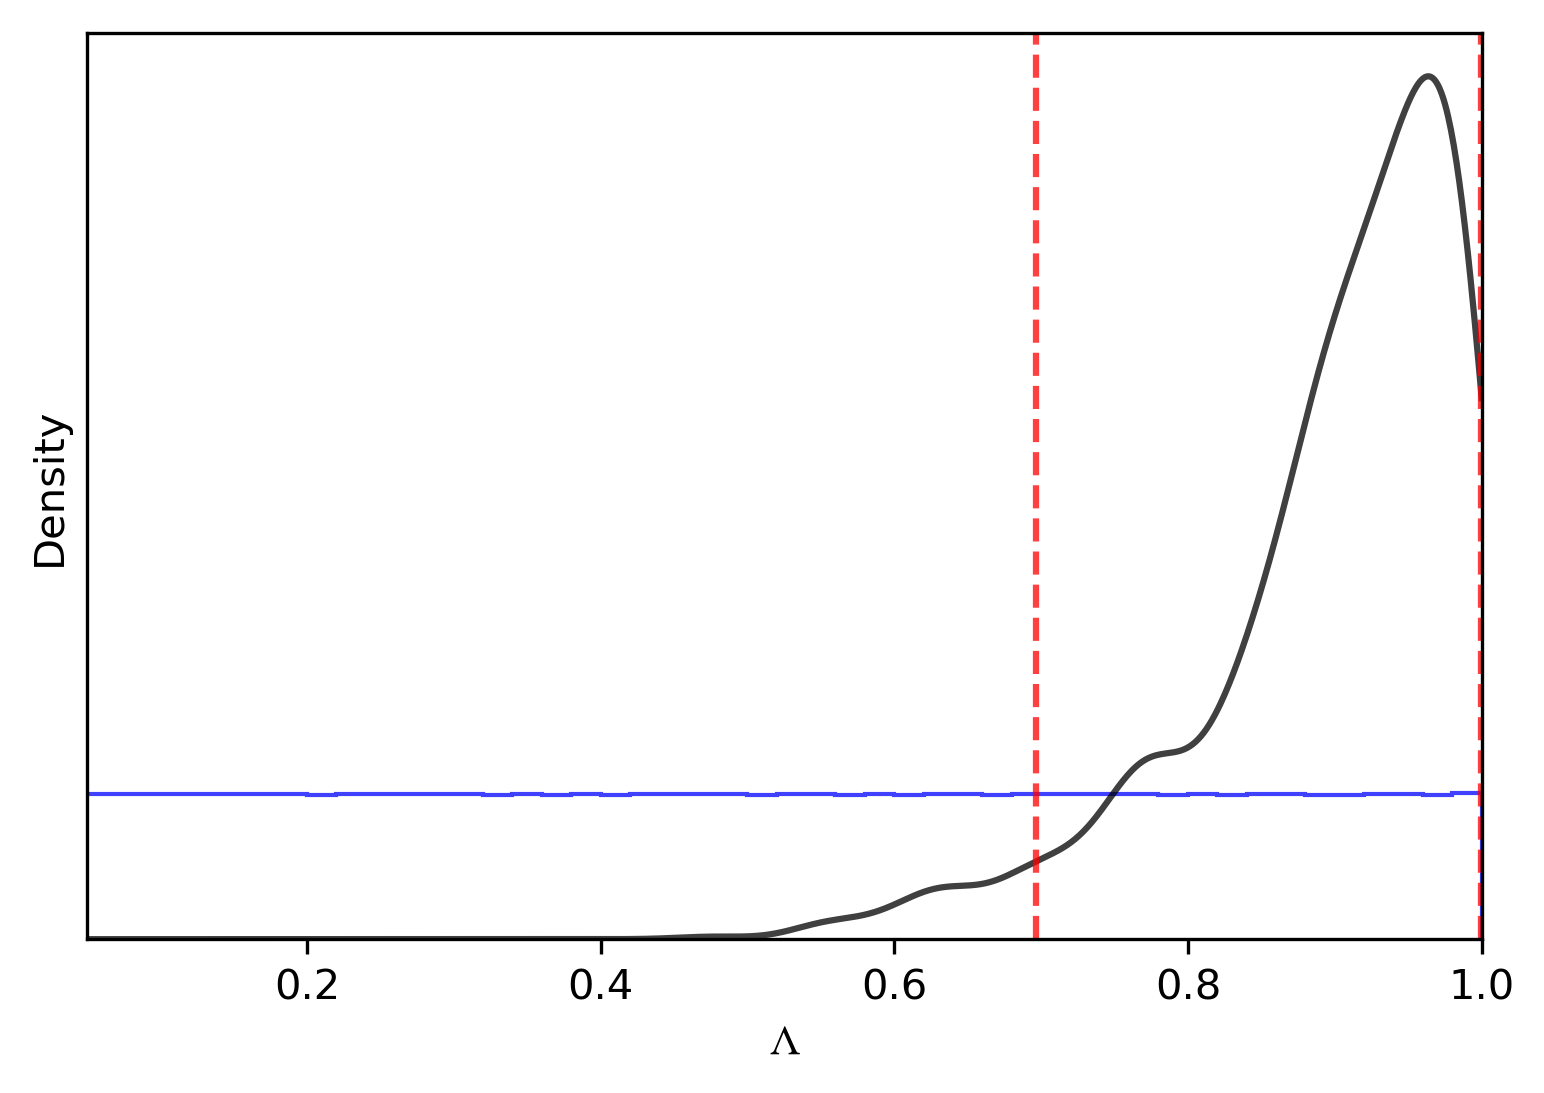

In [30]:
%R -o out out=resboth.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[3]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
X_plot = np.linspace(0.05, 1, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Λ", fontproperties=font)
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0.05, 1))
plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
plt.savefig("/home/isaac/gimmeSAD/spider-both-equilib-posterior.svg")

In [189]:
%%R
resboth.abc$ss

        shannon bin_0 bin_1 bin_2 bin_3 bin_4 bin_5 bin_6 bin_7 bin_8 bin_9
  [1,] 3.619345    66    25     4     3     2     2     0     0     0     1
  [2,] 4.018132    94    21     8     3     1     1     0     2     0     1
  [3,] 3.972584    99    25     4     4     0     0     0     2     0     1
  [4,] 3.507726    57    24     6     2     2     1     0     0     0     1
  [5,] 3.546550    54    23     2     3     0     2     0     0     1     1
  [6,] 3.844516    79    24     9     3     1     2     0     0     0     1
  [7,] 3.493213    55    20     6     1     0     1     2     1     0     1
  [8,] 3.785930    96    24     8     2     1     0     1     1     0     1
  [9,] 3.786658    78    25     5     3     1     1     0     0     0     1
 [10,] 3.576114    58    21     4     0     1     2     0     1     0     1
 [11,] 4.049747   129    26     6     4     1     3     1     1     0     1
 [12,] 4.061544   113    22     7     4     3     2     1     2     0     2
 [13,] 3.539

[ 8 25  7  4  1  3  2  4  1  2]
(10,)
(1000, 11)
[[  3.51320916  57.          23.           6.           2.
    0.           0.           0.           0.           0.
    1.        ]
 [  4.1248433  118.          25.           5.           3.
    1.           1.           0.           1.           0.
    1.        ]]
(1001, 10)
[ 8. 25.  7.  4.  1.  3.  2.  4.  1.  2.]
explained variance ratio (first two components): [0.97679034 0.00928669]


[]

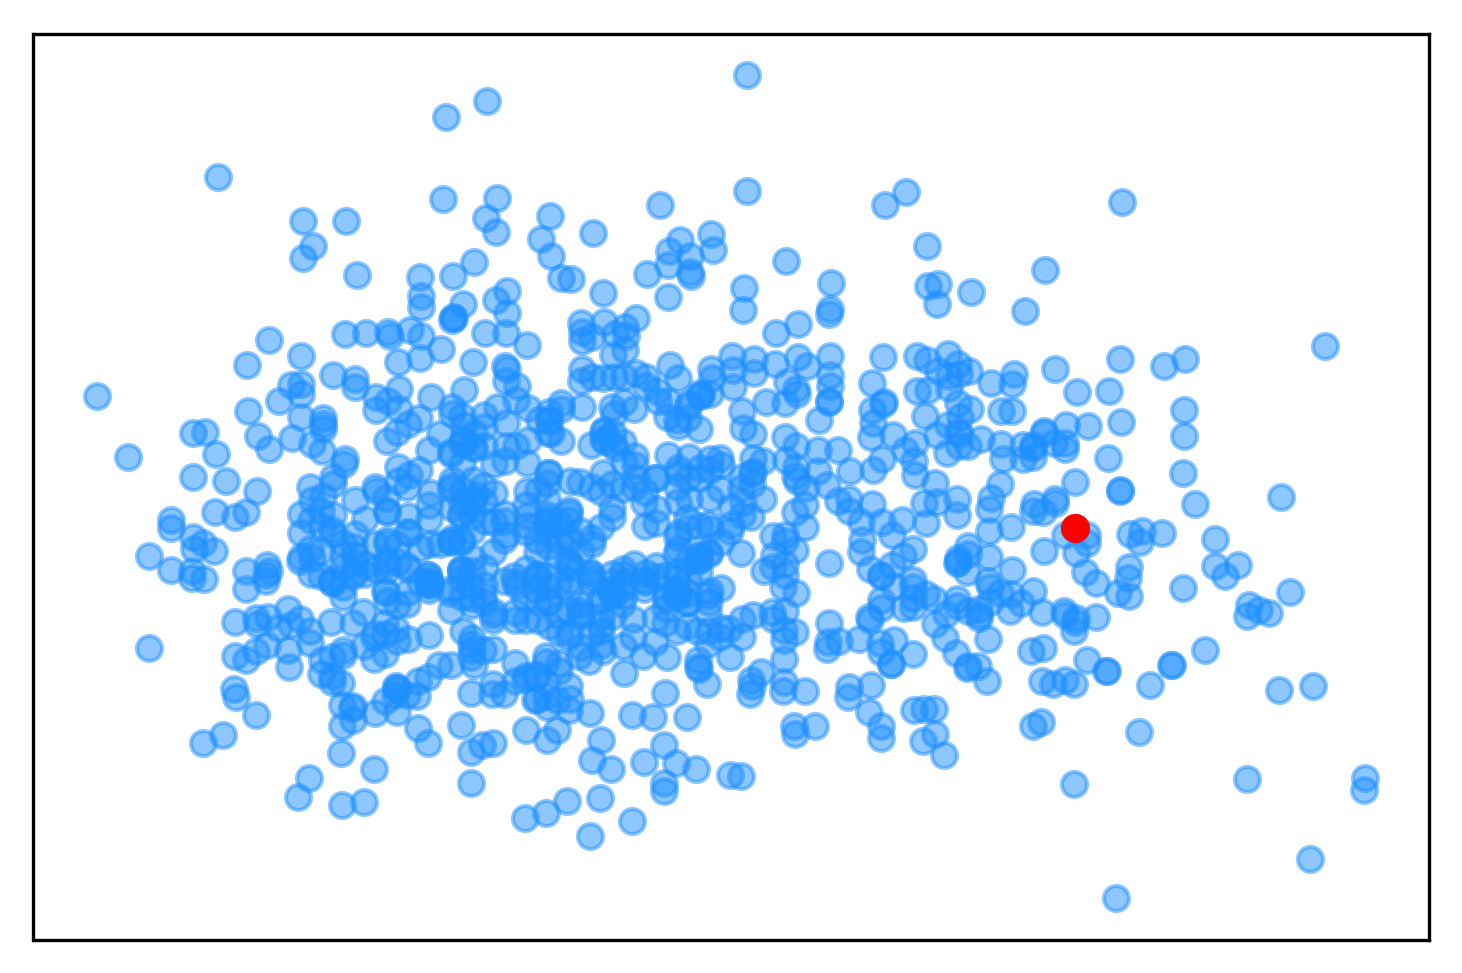

In [214]:
%R -o out out=resboth.abc$ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(OBSERVED_FILE).readlines()[1].split()[1:]])
print(OBS)
print(OBS.shape)
print(out.shape)
print(out[0:2])
out = np.delete(out, 0, axis=1)

dat = np.vstack([out, OBS])
print(dat.shape)
print(dat[-1])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure(dpi=300)
x, y = zip(*X_r)
plt.scatter(x, y, color='DodgerBlue', lw=1, alpha=0.5)
plt.scatter(x[-1], y[-1], c="r")

ax = plt.gca()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

# Estimate colonization rate using shannon index and 1d pi vector

6204616
6204616
('min bin size ', 399710)


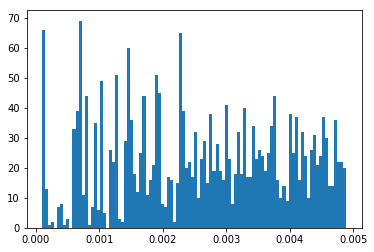

In [131]:
## Get a flat colonization rate prior

REF_TABLE = os.path.join(SIMOUT_DIR, "spider-priors.txt")
dat = pd.read_csv(REF_TABLE, sep="\t")
## Duplicate rows mess up the ABC
print(len(dat))
#dat.drop_duplicates(subset=["shannon", "bin_0", "bin_1", "bin_2", "bin_3", "bin_4",\
#                                        "bin_5", "bin_6", "bin_7", "bin_8", "bin_9"], inplace=True)
print(len(dat))
## scale everything to the smallest presumed bin
minct = np.count_nonzero(dat["%equil"] < 0.01)
print("min bin size ", minct)
## Truncate to a smaller number of sims
minct = 100

gt_val = 0.0005
outdf = dat[dat['colrate'] < gt_val].sample(n=minct, replace=False)
for lt_val in np.arange(0.0007, 0.005, 0.0002):
    gt = dat["colrate"] > gt_val
    lt = dat["colrate"] < lt_val
    gt_val = lt_val
    try:
        samps = dat[lt & gt]
        ## Watch this, it'll bite you with the replacement.
        tmpdf = samps.sample(n=minct, replace=False)
    except:
        print(lt_val, len(samps))
    outdf = pd.concat([outdf, tmpdf])
#outdf
_, _, _ = plt.hist(outdf["colrate"], bins=100)
outdf.to_csv(REF_TABLE, sep="\t", index=False)

Prediction error based on a cross-validation sample of 50

              eq
0.005 0.10610219
0.01  0.09760246
0.05  0.09416348


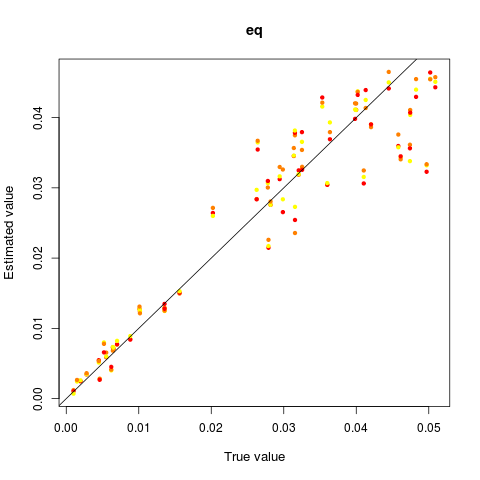

In [47]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"colrate"]), PRIOR[,7:17], nval=50, tols=c(.005, .01, 0.05), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "colrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.0025, method = "loclinear")
Data:
 abc.out$adj.values (1000 posterior samples)
Weights:
 abc.out$weights

                       colrate
Min.:                   0.0001
Weighted 2.5 % Perc.:   0.0002
Weighted Median:        0.0003
Weighted Mean:          0.0003
Weighted Mode:          0.0002
Weighted 97.5 % Perc.:  0.0006
Max.:                   0.0023
                            colrate
Min.:                  0.0001155559
Weighted 2.5 % Perc.:  0.0001768572
Weighted Median:       0.0003038840
Weighted Mean:         0.0003327970
Weighted Mode:         0.0002424107
Weighted 97.5 % Perc.: 0.0005971576
Max.:                  0.0022808073


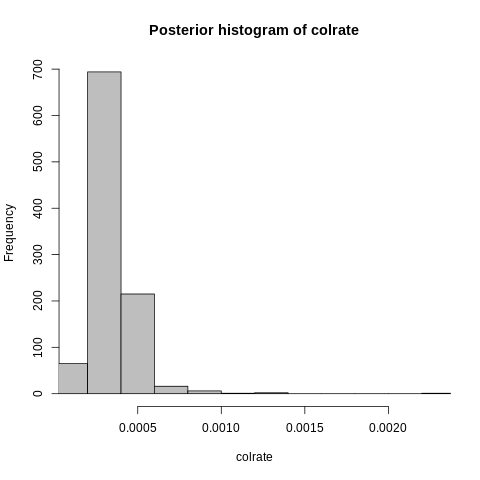

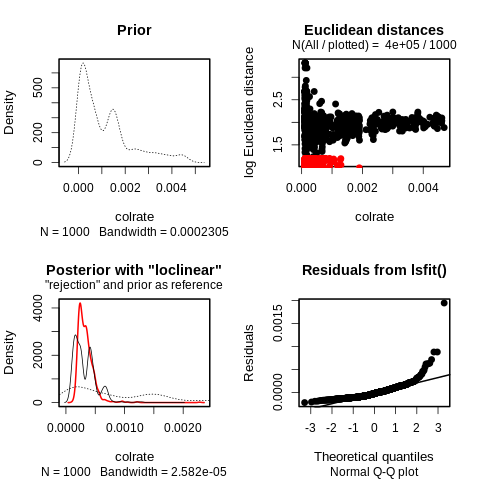

In [141]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"colrate"]), sumstat=PRIOR[,7:17], tol=0.0025, 
              method="loclinear")
print(summary(res.abc))
hist(res.abc)
plot(res.abc, param=PRIOR[,"colrate"])

0.00033613954693332724
[0.00016579 0.00055414]


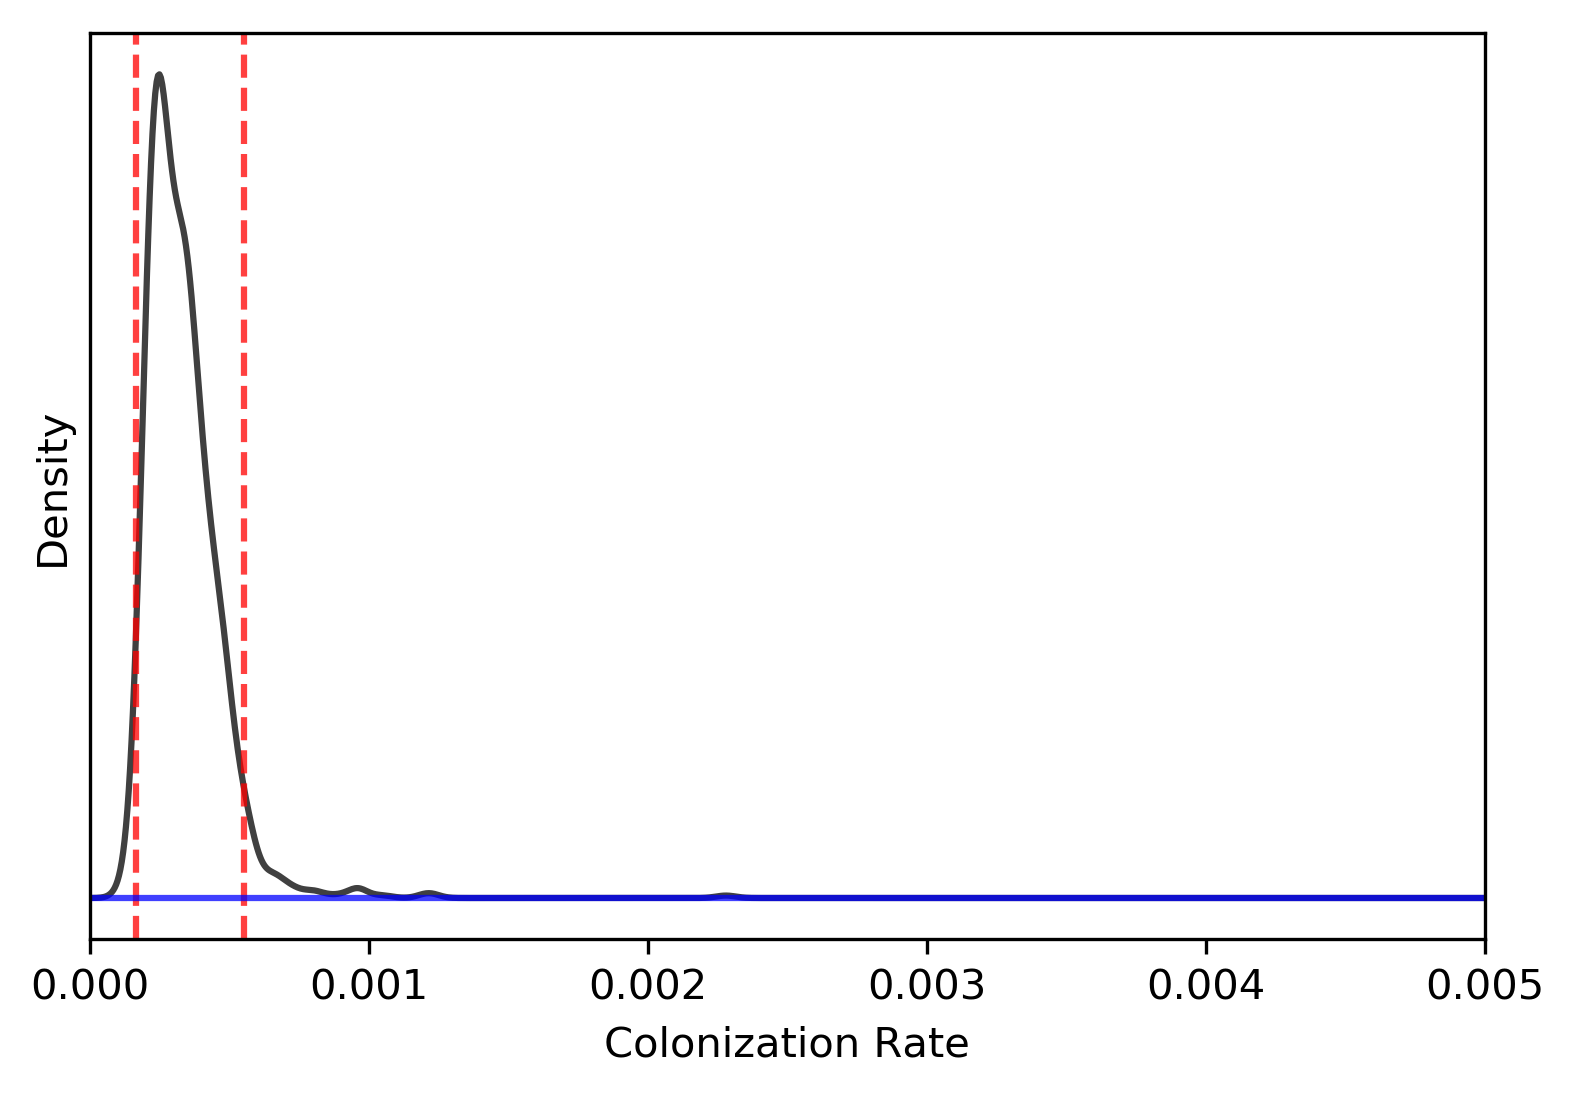

In [142]:
%R -o out out=res.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[1]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.005
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Colonization Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((xmin, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

plt.savefig("/home/isaac/gimmeSAD/spider-colrate-posterior.svg")

## Estimate extinction rate using shannon index and 1d pi vector

Call: 
abc(target = OBS, param = data.frame(extrate = PRIOR[, "extrate"]), 
    sumstat = PRIOR[, 7:17], tol = 0.0025, method = "loclinear")
Data:
 abc.out$adj.values (1000 posterior samples)
Weights:
 abc.out$weights

                       extrate
Min.:                   0.0001
Weighted 2.5 % Perc.:   0.0002
Weighted Median:        0.0003
Weighted Mean:          0.0003
Weighted Mode:          0.0002
Weighted 97.5 % Perc.:  0.0006
Max.:                   0.0023
                            extrate
Min.:                  0.0001124080
Weighted 2.5 % Perc.:  0.0001744748
Weighted Median:       0.0003033790
Weighted Mean:         0.0003324166
Weighted Mode:         0.0002399157
Weighted 97.5 % Perc.: 0.0005994730
Max.:                  0.0022903300


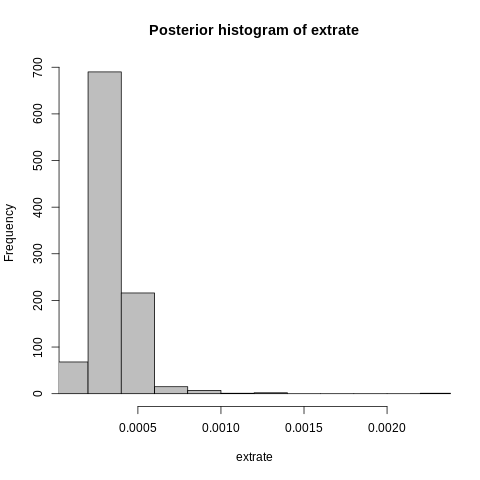

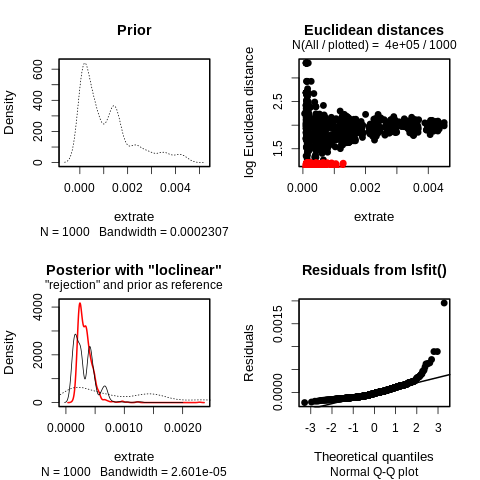

In [139]:
%%R
res.abc = abc(target=OBS, param=data.frame(extrate=PRIOR[,"extrate"]), sumstat=PRIOR[,7:17], tol=0.0025, 
              method="loclinear")
print(summary(res.abc))
hist(res.abc)
plot(res.abc, param=PRIOR[,"extrate"])

0.00033578624639286046
[0.000163   0.00055649]


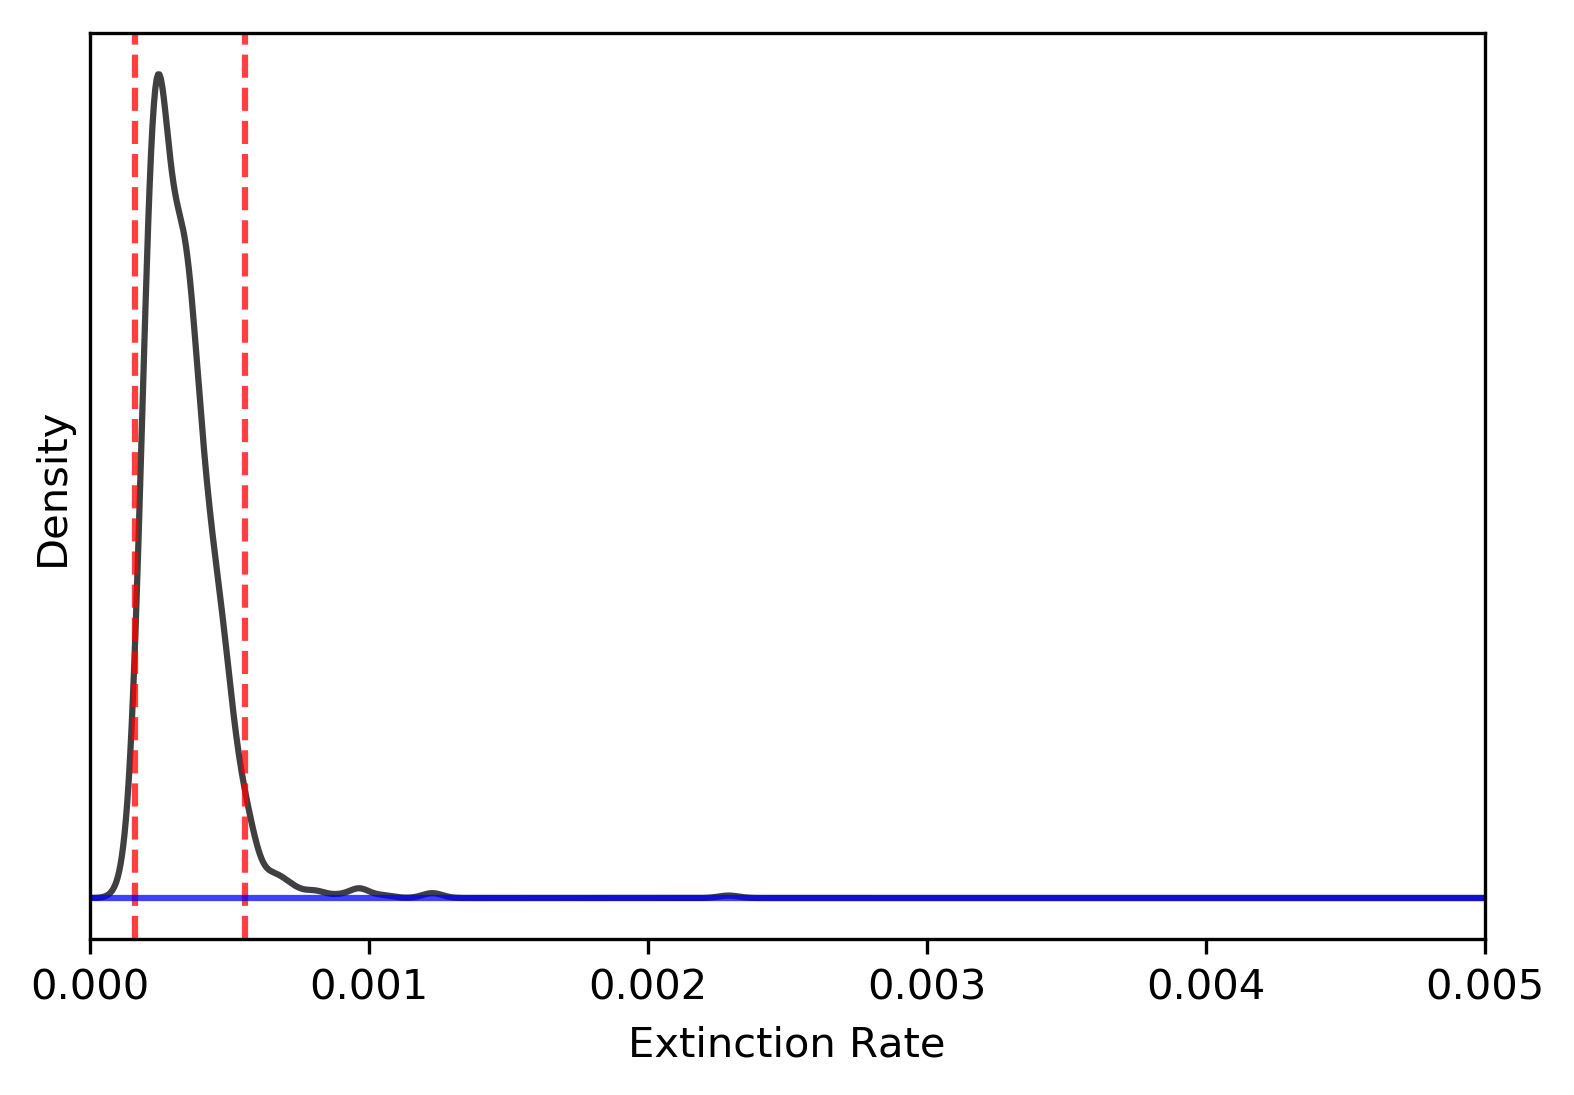

In [140]:
%R -o out out=res.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[5]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
xmin = 0
xmax = 0.005
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Extinction Rate")
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((xmin, xmax))
#plt.ylim((0,0.01))

#plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

plt.savefig("/home/isaac/gimmeSAD/spider-extrate-posterior.svg")

## Estimate local community size

Call: 
abc(target = OBS, param = data.frame(colrate = PRIOR[, "K"]), 
    sumstat = PRIOR[, 7:17], tol = 0.0025, method = "loclinear")
Data:
 abc.out$adj.values (1000 posterior samples)
Weights:
 abc.out$weights

                         colrate
Min.:                   5907.647
Weighted 2.5 % Perc.:   8156.098
Weighted Median:        9883.215
Weighted Mean:          9748.752
Weighted Mode:         10347.299
Weighted 97.5 % Perc.: 10856.803
Max.:                  13373.614
                         colrate
Min.:                   5907.647
Weighted 2.5 % Perc.:   8156.098
Weighted Median:        9883.215
Weighted Mean:          9748.752
Weighted Mode:         10347.298
Weighted 97.5 % Perc.: 10856.803
Max.:                  13373.614


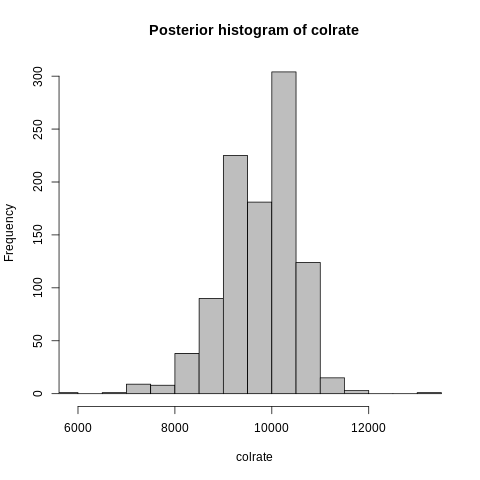

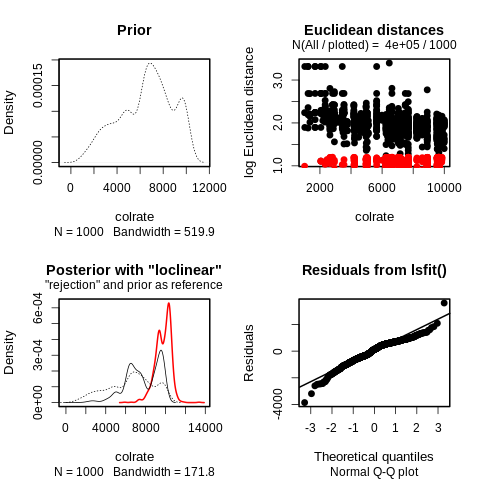

In [145]:
%%R
res.abc = abc(target=OBS, param=data.frame(colrate=PRIOR[,"K"]), sumstat=PRIOR[,7:17], tol=0.0025, 
              method="loclinear")
print(summary(res.abc))
hist(res.abc)
plot(res.abc, param=PRIOR[,"K"])

## Estimate shannon using only 1d pi vector

Prediction error based on a cross-validation sample of 50

           shan
0.001 0.1045623
0.005 0.1009718
0.01  0.1033770


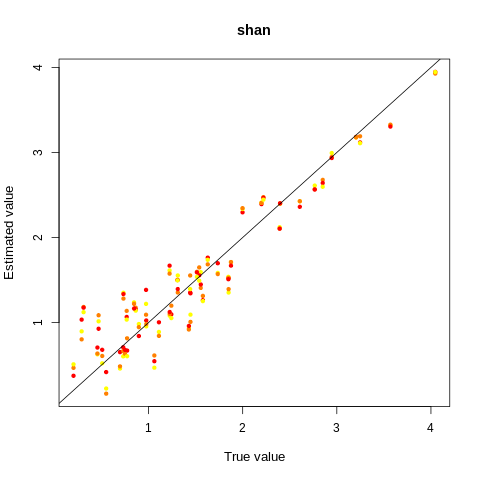

In [54]:
%%R
cv.res.reg <- cv4abc(data.frame(shan=PRIOR[,"shannon"]), PRIOR[,8:17], nval=50, tols=c(.001, .005, .01), method="rejection")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS[3:11], param = data.frame(shan = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 9:17], tol = 0.0025, method = "rejection", 
    numnet = 10, lambda = 1)
Data:
 abc.out$unadj.values (1000 posterior samples)

               shan
Min.:        0.7348
2.5% Perc.:  1.1715
Median:      1.9623
Mean:        1.9979
Mode:        1.8156
97.5% Perc.: 2.8221
Max.:        3.2685
                  shan
Min.:        0.7348014
2.5% Perc.:  1.1714656
Median:      1.9622508
Mean:        1.9978789
Mode:        1.8155893
97.5% Perc.: 2.8220940
Max.:        3.2685412


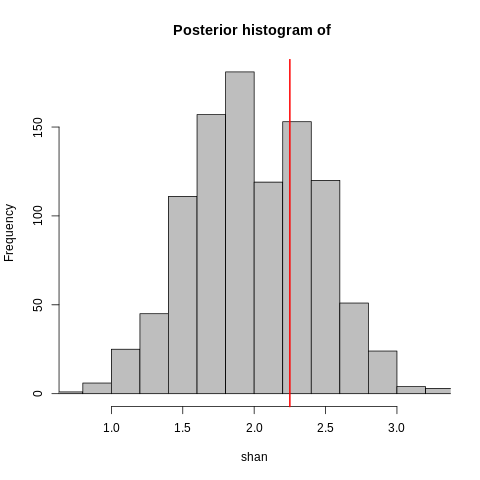

In [90]:
%%R
## w/o 'veil line'
#res1d.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,8:17],
#                tol=0.0025, method="rejection", numnet=30, lambda=0.01)
## w/ veil line
res1d.abc = abc(target=OBS[3:11], param=data.frame(shan=PRIOR[,"shannon"]), sumstat=PRIOR[,9:17],
                tol=0.0025, method="rejection", numnet=10, lambda=1)
print(summary(res1d.abc))
hist(res1d.abc, true=2.25, cap="", breaks=10)
#plot(res.abc, param=PRIOR[,"shannon"])

2.24620615576744
1.99787887167743
[1.27068456 2.8782291 ]


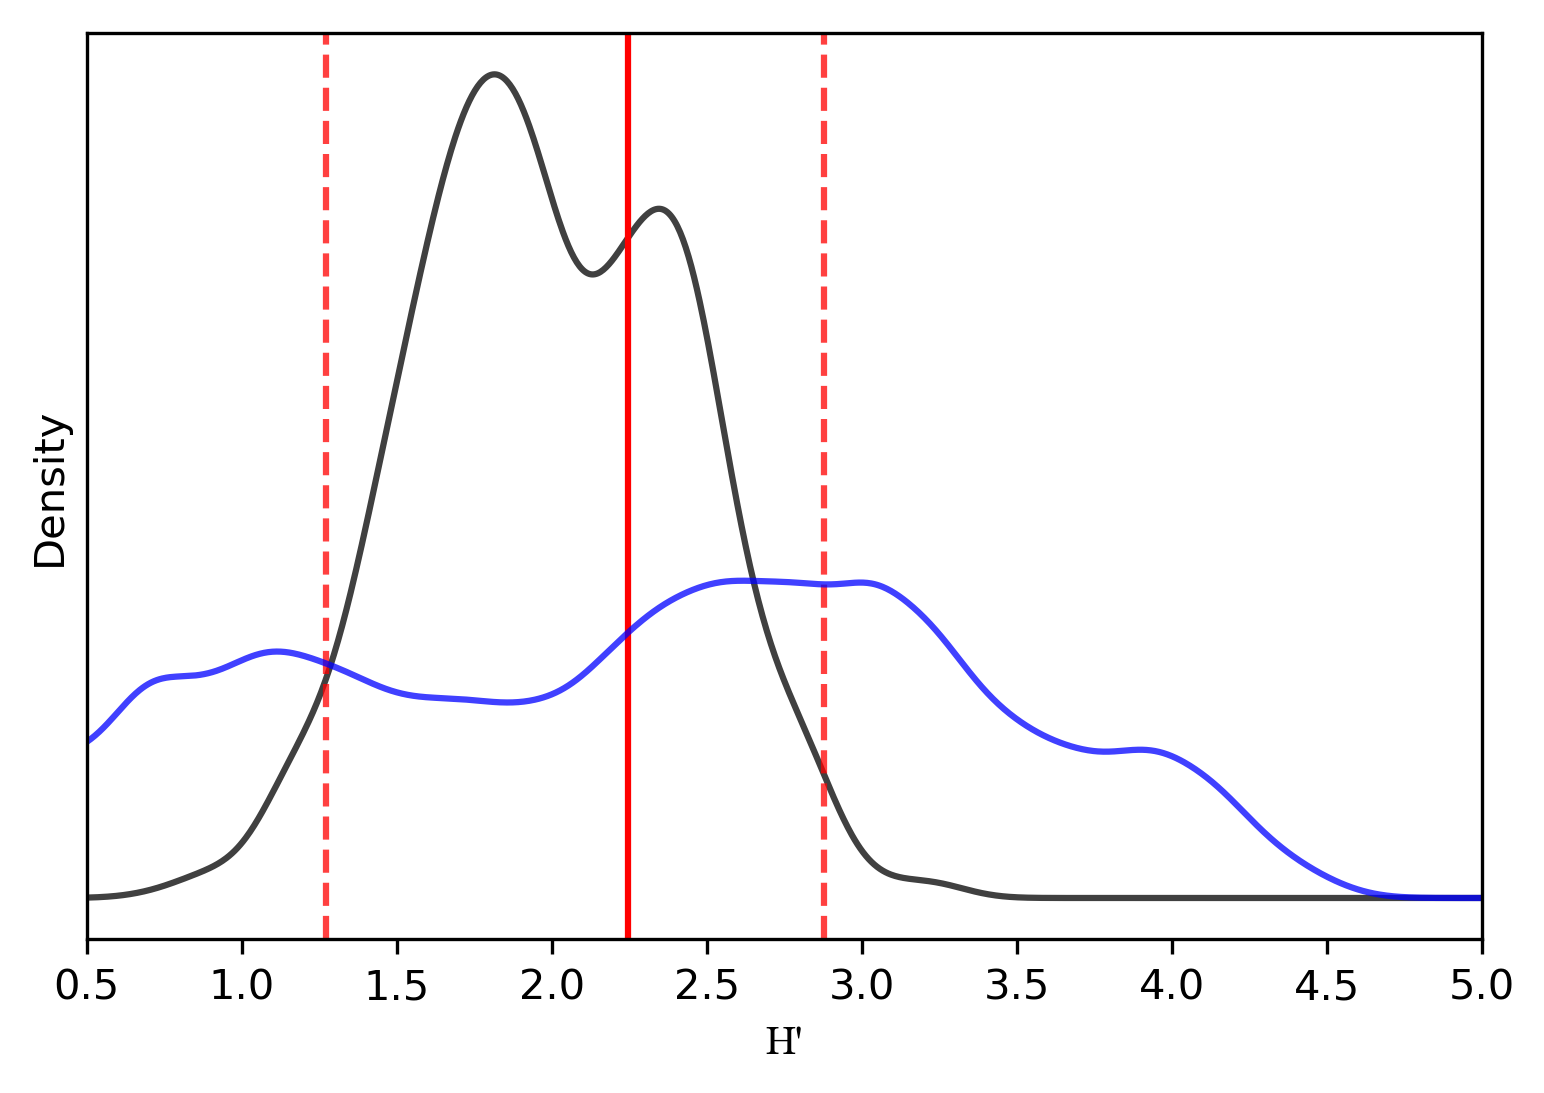

In [112]:
%R -o out out=res1d.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3
import scipy
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()


## Get shannon prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]

shan_dat = []
for line in lines:
    try:
        shan_dat.append(float(line[6]))
    except:
        pass


## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([float(x) for x in open(OBSERVED_FILE).readlines()[1].split()[:1]])[0]
print(OBS)
#print(out.shape)
shans = np.array(out[0]).ravel()
print(np.mean(shans))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])
#_, _, _ = plt.hist(shans, bins=75, color='grey', lw=1, normed=True)

xmin = 0.5
xmax = 5
## KDE
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shans)
plt.plot(X_plot, kde(X_plot), color='black', alpha=0.75)

plt.axvline(OBS, color='r', linestyle='-')
xs = pymc3.stats.hpd(shans)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)
## Truncate to make it look nicer
plt.xlim((xmin, xmax))

#plt.hist(shan_dat, bins=100, histtype="step", normed=True, color='b', alpha=0.75)
X_plot = np.linspace(xmin, xmax, 1000)
kde = scipy.stats.gaussian_kde(shan_dat)
plt.plot(X_plot, kde(X_plot), color='blue', alpha=0.75)

font.set_family('Times New Roman')
plt.xlabel(u"H'", fontproperties=font)
plt.ylabel(u"Density")

plt.savefig("/home/isaac/gimmeSAD/spider-shannon-posterior.svg")

In [103]:
pymc3.stats.hpd(shans)[0]

1.2706845550299999

## Estimate %equil using only 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 1.0994504
0.005 0.7967177
0.01  0.6369830


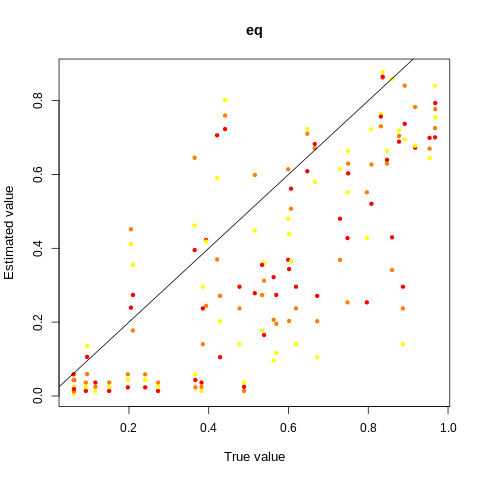

In [60]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,9:17], nval=50, tols=c(.001, .005, .01), method="rejection")
print(summary(cv.res.reg))
plot(cv.res.reg)

### Would be good to implement a 'veil line' for undetected species in the empirical dataset

We can fake this by just dropping the singleton bin, here's the code w/o the veil line

`res.abc = abc(target=OBS[2:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.05, method="neuralnet")`

In [52]:
%%R
reseq.abc = abc(target=OBS[2:11], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,8:17], tol=0.0025,
                method="rejection", numnet=10, lambda=1)
print(summary(reseq.abc))
#print(res.abc$ss)
hist(reseq.abc)
hist(reseq.abc$adj.values)
#hist(res.abc$dist)
plot(reseq.abc, param=PRIOR[,"X.equil"])


Call: 
abc(target = OBS[2:11], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 8:17], tol = 0.0025, method = "rejection", 
    numnet = 10, lambda = 1)
Data:
 abc.out$unadj.values (1000 posterior samples)

                 eq
Min.:        0.4767
2.5% Perc.:  0.6381
Median:      0.9221
Mean:        0.8962
Mode:        0.9687
97.5% Perc.: 0.9969
Max.:        0.9999
                    eq
Min.:        0.4767123
2.5% Perc.:  0.6380732
Median:      0.9221174
Mean:        0.8961628
Mode:        0.9687148
97.5% Perc.: 0.9968686
Max.:        0.9998835
Error in hist.default(reseq.abc$adj.values) : 'x' must be numeric


In [31]:
%%R
reseq.abc = abc(target=OBS[3:11], param=data.frame(eq=PRIOR[,"shannon"]), sumstat=PRIOR[,9:17], tol=0.03,
                method="rejection", numnet=30, lambda=0.001)
print(summary(reseq.abc))
#print(res.abc$ss)
hist(reseq.abc)
hist(reseq.abc$adj.values)
#hist(res.abc$dist)
plot(reseq.abc, param=PRIOR[,"shannon"])


Call: 
abc(target = OBS[3:11], param = data.frame(eq = PRIOR[, "shannon"]), 
    sumstat = PRIOR[, 9:17], tol = 0.03, method = "rejection", 
    numnet = 30, lambda = 0.001)
Data:
 abc.out$unadj.values (12000 posterior samples)

                 eq
Min.:        2.4744
2.5% Perc.:  3.1502
Median:      3.9141
Mean:        3.8594
Mode:        3.9762
97.5% Perc.: 4.4183
Max.:        4.6486
                   eq
Min.:        2.474409
2.5% Perc.:  3.150184
Median:      3.914138
Mean:        3.859361
Mode:        3.976164
97.5% Perc.: 4.418319
Max.:        4.648645
Error in hist.default(reseq.abc$adj.values) : 'x' must be numeric


/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in hist.default(reseq.abc$adj.values) : 'x' must be numeric

  warnings.warn(x, RRuntimeWarning)


0.896162800269918
[0.69513063 0.9998835 ]


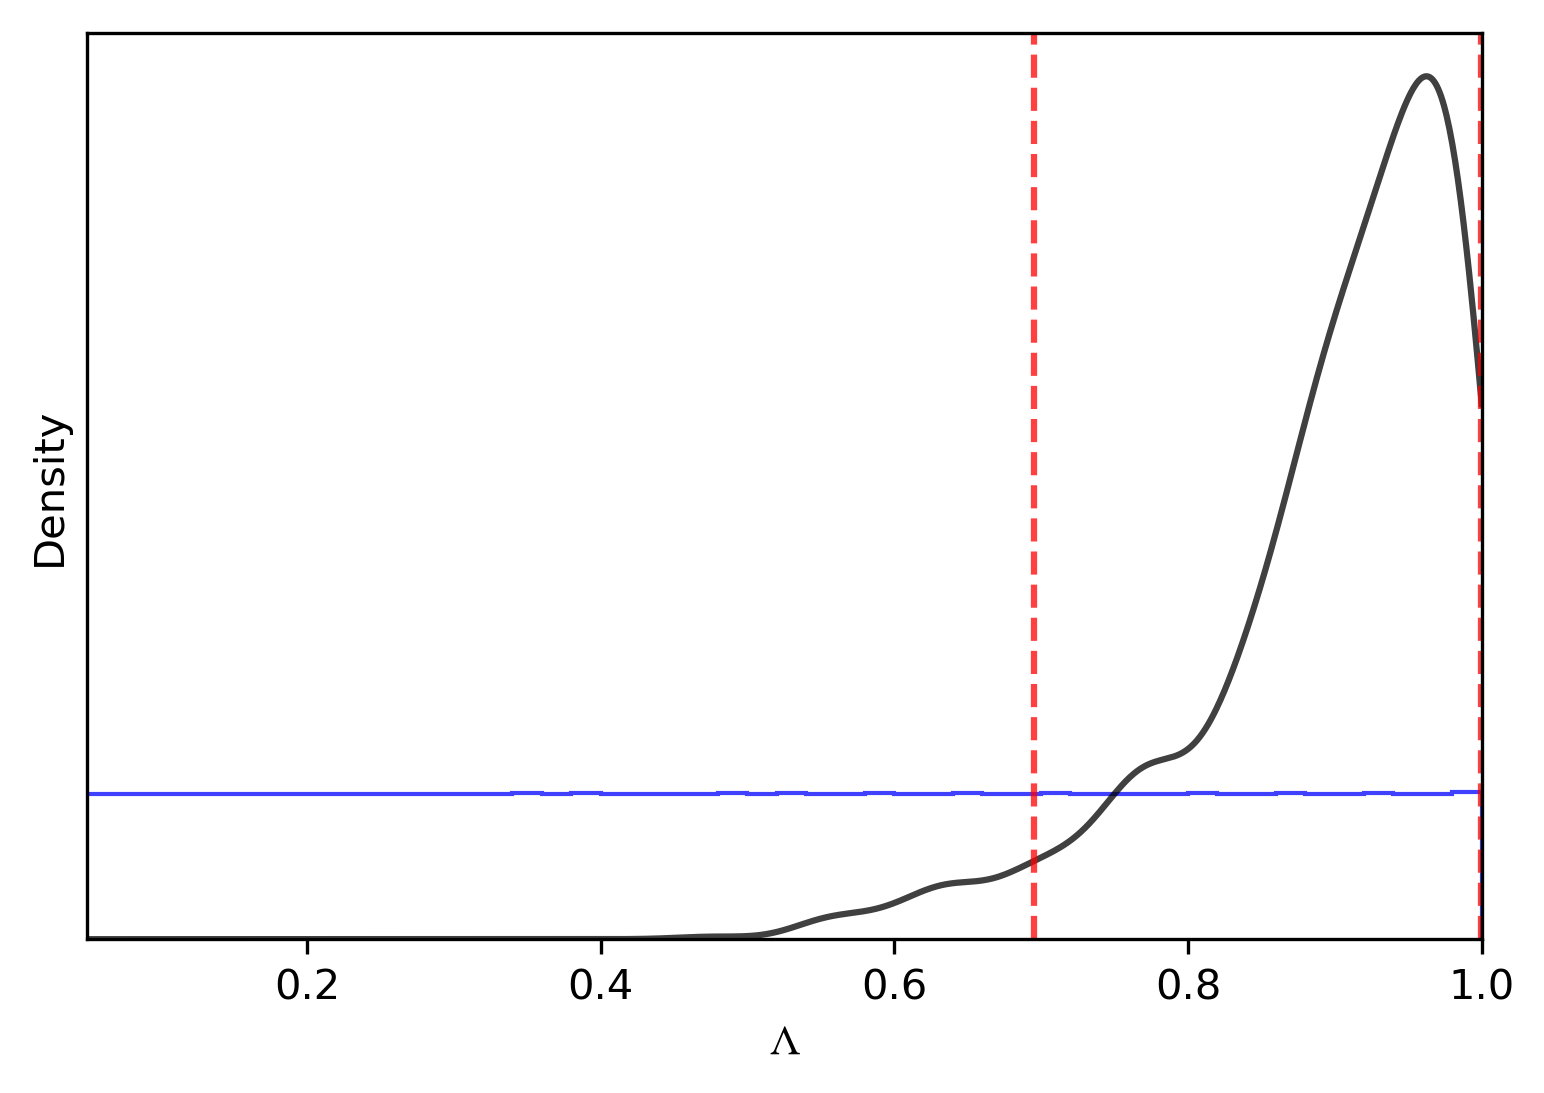

In [54]:
%R -o out out=reseq.abc
from sklearn.decomposition import PCA
import scipy
import matplotlib.pyplot as plt
import pymc3
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()

## Get lambda prior
f = open(REF_TABLE).readlines()
lines = [line.split("\t") for line in f]
lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[3]))
    except:
        pass
#n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
eqs = eqs[eqs <= 1.0]
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

ax = fig.gca()
ax.get_yaxis().set_ticks([])

## Histogram of posterior samples
#_, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)

## KDE
X_plot = np.linspace(0.05, 1, 1000)
kde = scipy.stats.gaussian_kde(eqs)
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

## HPD
xs = pymc3.stats.hpd(eqs)
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(xs[1], color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Λ", fontproperties=font)
plt.ylabel(u"Density")
## Truncate to show all or part of prior
plt.xlim((0.05, 1))
plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
plt.savefig("/home/isaac/gimmeSAD/spider-1d-equilib-posterior.svg")

## Prior goodness of fit test for retained simulations

[ 8 25  7  4  1  3  2  4  1  2]
(10,)
(1000, 10)
[[47. 16.  0.  0.  0.  0.  0.  0.  0.  1.]
 [39. 14.  3.  0.  0.  0.  0.  0.  0.  1.]]
(1001, 10)
[ 8. 25.  7.  4.  1.  3.  2.  4.  1.  2.]
explained variance ratio (first two components): [0.94741086 0.02890846]


[]

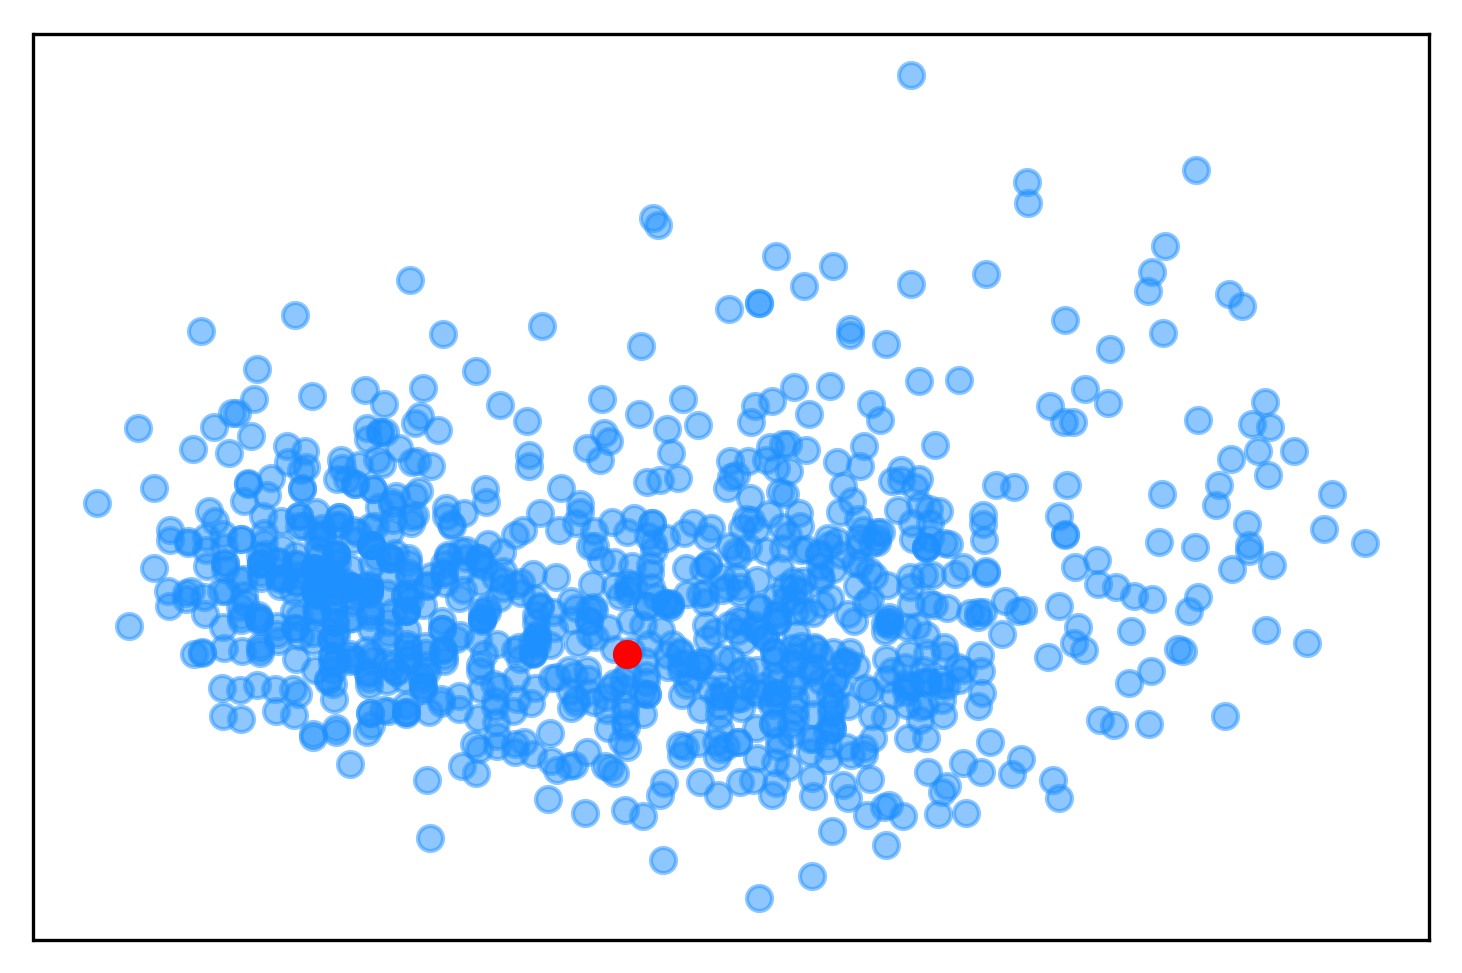

In [174]:
%R -o out out=reseq.abc$ss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Read in observed data
## `split()[2:]` drops the H' and the first bin, implementing a veil line
OBS = np.array([int(x) for x in open(OBSERVED_FILE).readlines()[1].split()[1:]])
print(OBS)
print(OBS.shape)
print(out.shape)
print(out[0:2])

dat = np.vstack([out, OBS])
print(dat.shape)
print(dat[-1])
pca = PCA(n_components=2)
X_r = pca.fit(out).transform(out)
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
plt.figure(dpi=300)
x, y = zip(*X_r)
plt.scatter(x, y, color='DodgerBlue', lw=1, alpha=0.5)
plt.scatter(x[-1], y[-1], c="r")

ax = plt.gca()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

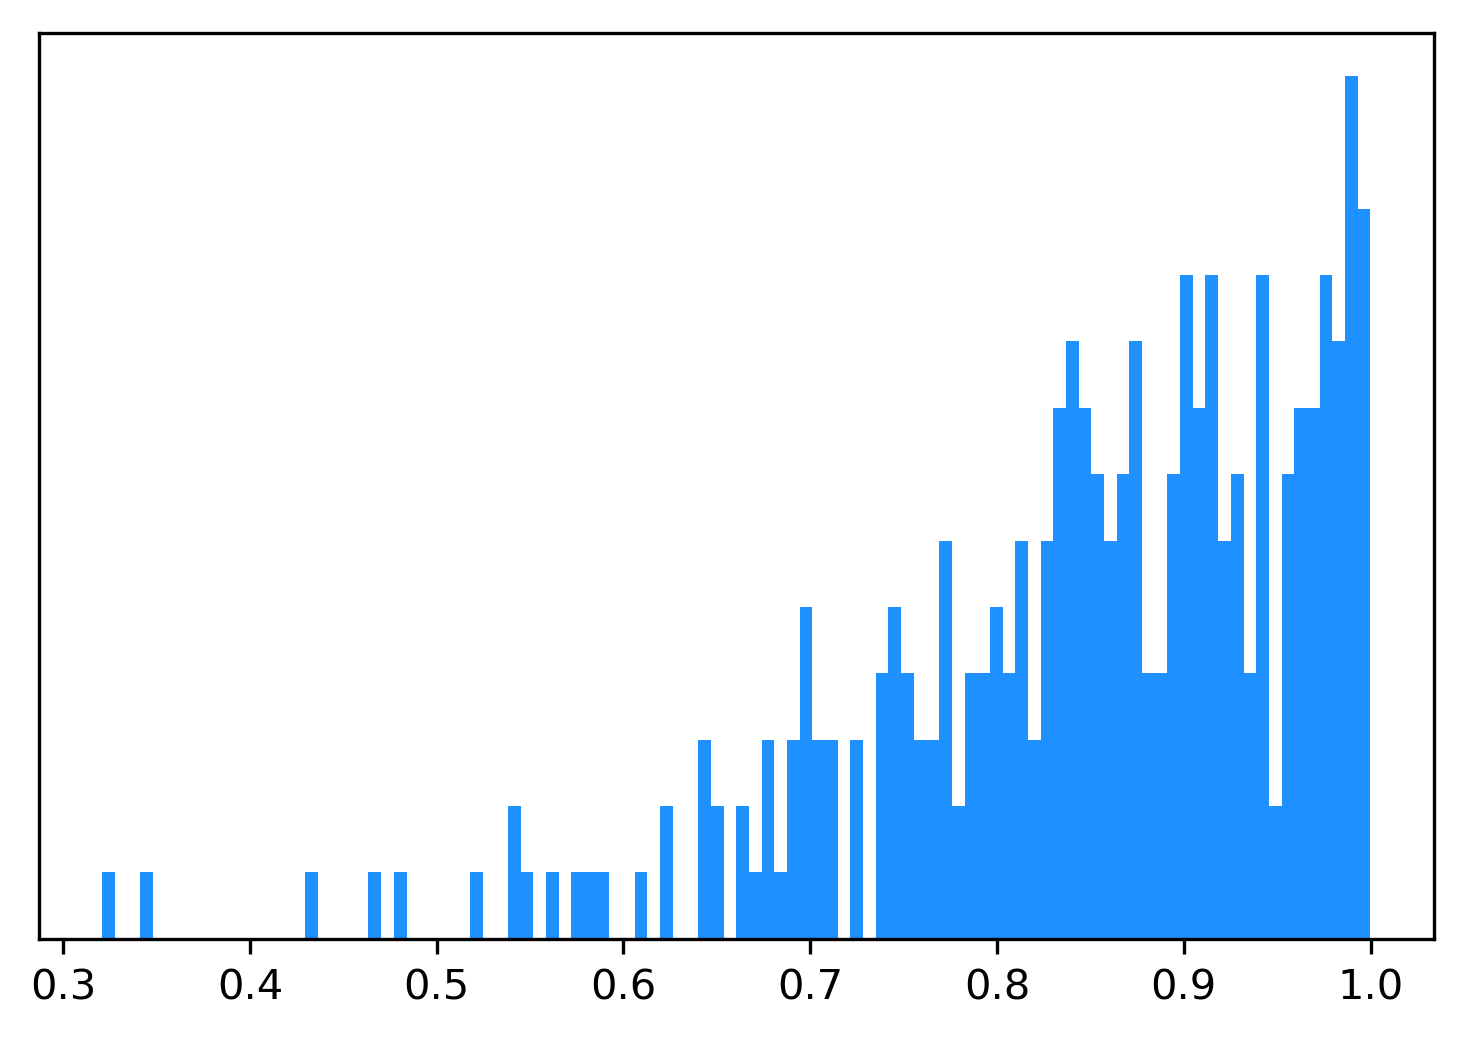

In [147]:
%R -o out out=reseq.abc$unadj.values
adj = np.array([x[0] for x in out])
adj = adj[adj < 1]
fig = plt.figure(dpi=300)
ax = fig.gca()
ax.get_yaxis().set_ticks([])
_, _, _ = plt.hist(adj, bins=100, color='DodgerBlue', lw=1)

2.24620615576744
29.048304416860226


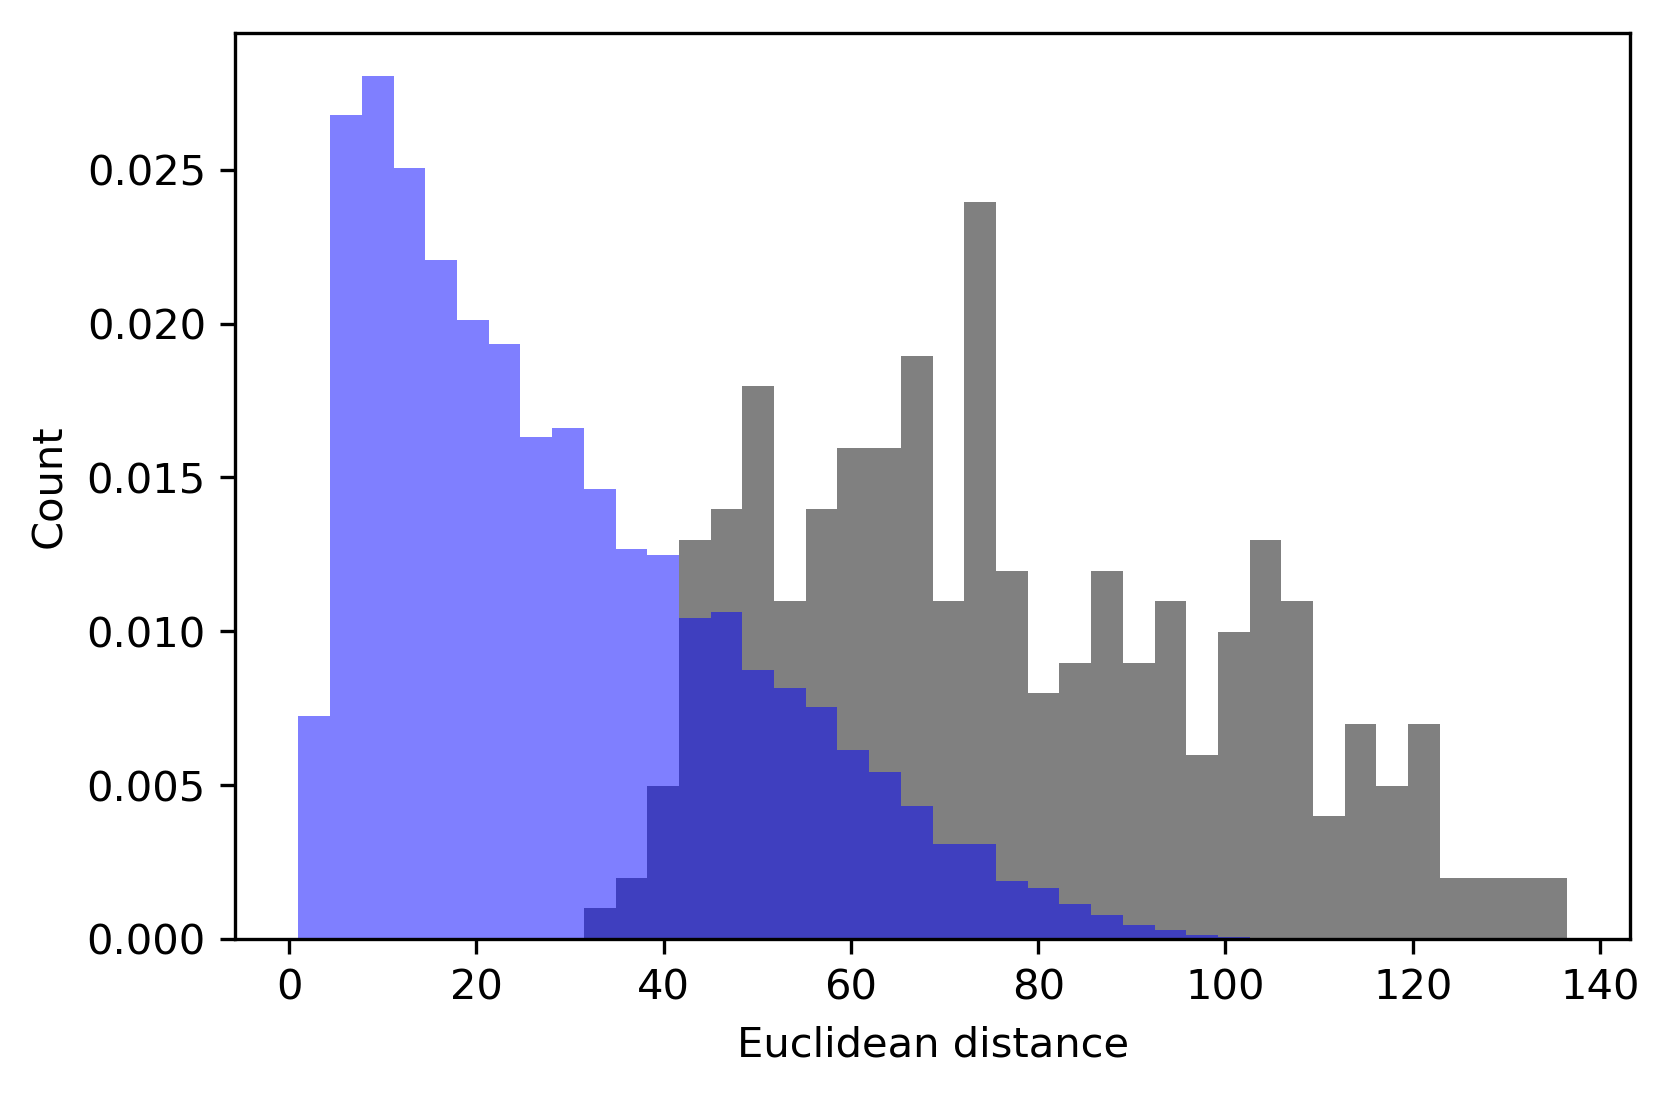

In [148]:
%R -o out out=reseq.abc$ss

from scipy.spatial.distance import euclidean, pdist

OBS = np.array([float(x) for x in open(OBSERVED_FILE).readlines()[1].split()[:1]])[0]
print(OBS)

dist = []
self_dist = pdist(out, metric="euclidean")
print(np.mean(self_dist))
for vec in out:
    dist.append(euclidean(vec, OBS))
fig = plt.figure(dpi=300)
ax = fig.gca()
#ax.get_yaxis().set_ticks([])
bins=np.histogram(np.hstack((dist, self_dist)), bins=40)[1]
n, _, _ = plt.hist(dist, bins, color='grey', lw=1, normed=True)
n, _, _ = plt.hist(self_dist, bins, color='blue', lw=1, normed=True, alpha=0.5)
plt.xlabel("Euclidean distance")
plt.ylabel("Count")
plt.savefig("/home/isaac/gimmeSAD/spider-euclidean.svg")


## Estimate %equil using only shannon

In [149]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"X.equil"]), PRIOR[,7], nval=100, tols=c(.05, .01, .005), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)


Error in abc(target = mytarget, param = myparam, sumstat = mysumstat,  : 
  Zero variance in the summary statistics in the selected region. Try: checking summary statistics, choosing larger tolerance, or rejection method.


In [32]:
%%R
resshaneq.abc = abc(target=OBS[,1], param=data.frame(eq=PRIOR[,"X.equil"]), sumstat=PRIOR[,7], tol=0.0025, 
                    method="rejection", lambda=0.1, numnet=5)
print(summary(resshaneq.abc))
hist(resshaneq.abc)
plot(resshaneq.abc, param=PRIOR[,"X.equil"])

Call: 
abc(target = OBS[, 1], param = data.frame(eq = PRIOR[, "X.equil"]), 
    sumstat = PRIOR[, 7], tol = 0.0025, method = "rejection", 
    numnet = 5, lambda = 0.1)
Data:
 abc.out$unadj.values (1000 posterior samples)

                 eq
Min.:        0.0144
2.5% Perc.:  0.0620
Median:      0.5406
Mean:        0.5319
Mode:        0.3862
97.5% Perc.: 0.9376
Max.:        0.9978
                     eq
Min.:        0.01439669
2.5% Perc.:  0.06197577
Median:      0.54055556
Mean:        0.53188720
Mode:        0.38620974
97.5% Perc.: 0.93757330
Max.:        0.99782923
Error in plot.abc(resshaneq.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE


/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in plot.abc(resshaneq.abc, param = PRIOR[, "X.equil"]) : 
  Diagnostic plots can be displayed only when method is "loclinear", "neuralnet" or "ridge".FALSE

  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In abc(target = OBS[, 1], param = data.frame(eq = PRIOR[, "X.equil"]),  :
  warnings.warn(x, RRuntimeWarning)
/home/isaac/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  No summary statistics names are given, using S1, S2, ...

  warnings.warn(x, RRuntimeWarning)


0.5318871965474459
[0.05748663 0.92677485]


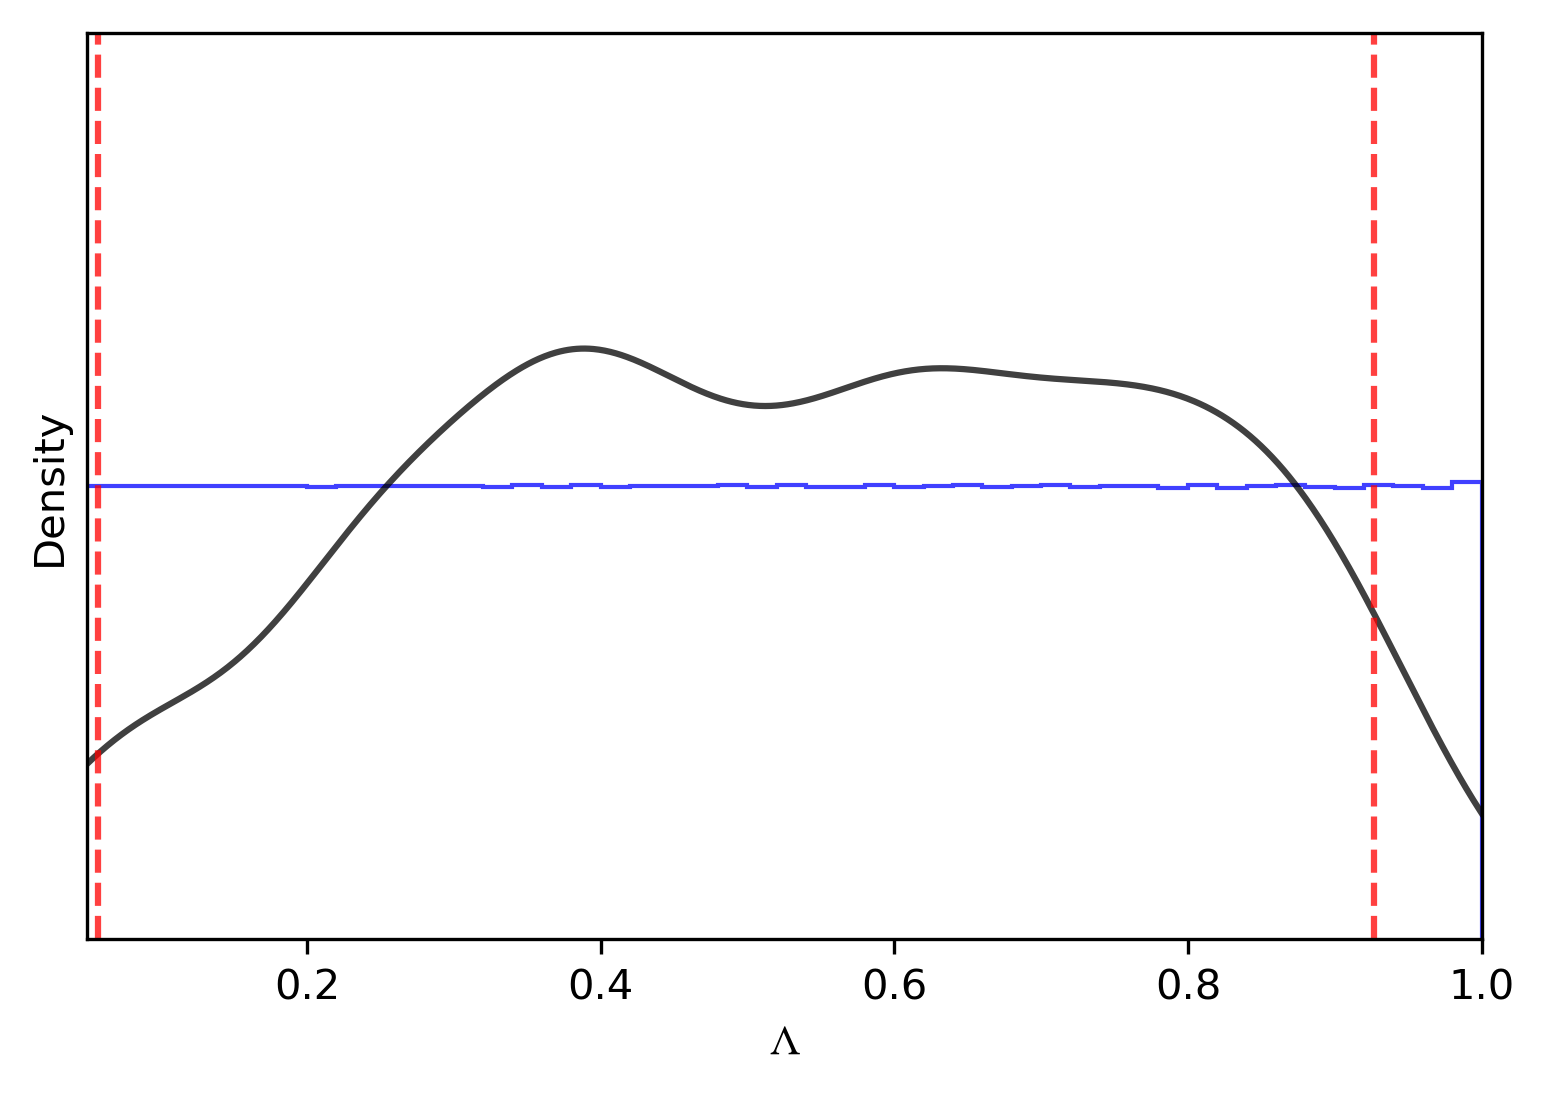

In [51]:
%R -o out out=resshaneq.abc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pymc3
import scipy
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.font_manager._rebuild()
## Read in observed data

#print(out.shape)
eqs = np.array(out[0])
print(np.mean(eqs))
fig = plt.figure(dpi=300)
plt.rcParams["font.family"] = "Helvetica"

## KDE
X_plot = np.linspace(0.05, 1, 1000)
kde = scipy.stats.gaussian_kde([x[0] for x in eqs])
plt.plot(X_plot, kde(X_plot), alpha=0.75, color='black')

ax = fig.gca()
ax.get_yaxis().set_ticks([])
## Histogram
## _, _, _ = plt.hist(eqs, bins=75, color='grey', lw=1, normed=True)
xs = pymc3.stats.hpd(eqs)[0]
print(xs)
plt.axvline(xs[0], color='r', linestyle='--', alpha=0.75)
plt.axvline(min(1, xs[1]), color='r', linestyle='--', alpha=0.75)

font = FontProperties()
font.set_family('Times New Roman')
plt.xlabel(u"Λ", fontproperties=font)
plt.ylabel(u"Density")

plt.xlim((0.05, 1.00))
plt.ylim((0, 2))
plt.hist(lamb_dat, bins=50, histtype="step", normed=True, color='b', alpha=0.75)
plt.savefig("/home/isaac/gimmeSAD/spider-shan-equilib-posterior.svg")

In [44]:
np.array(eqs)

array([[0.01439669],
       [0.01869822],
       [0.01871247],
       [0.02090008],
       [0.0314348 ],
       [0.0311123 ],
       [0.03943772],
       [0.03634669],
       [0.03634669],
       [0.04971517],
       [0.04664765],
       [0.04720011],
       [0.04739693],
       [0.04971517],
       [0.04971517],
       [0.04139008],
       [0.0599541 ],
       [0.05748663],
       [0.0599541 ],
       [0.05306705],
       [0.05538993],
       [0.0599541 ],
       [0.05292479],
       [0.05783917],
       [0.06197577],
       [0.06197577],
       [0.06762994],
       [0.06782334],
       [0.065481  ],
       [0.06782334],
       [0.06920821],
       [0.07366141],
       [0.072647  ],
       [0.07446092],
       [0.07744371],
       [0.07531775],
       [0.08444552],
       [0.08444552],
       [0.08975549],
       [0.08086253],
       [0.08546721],
       [0.08962264],
       [0.09816147],
       [0.0965858 ],
       [0.09586256],
       [0.09176592],
       [0.10358849],
       [0.108

## Estimate island size using shannon and 1d pi vector

Prediction error based on a cross-validation sample of 50

             eq
0.001 0.6453266
0.005 0.3867152
0.01  0.3609488
0.05  0.3812574
0.1   0.3750593


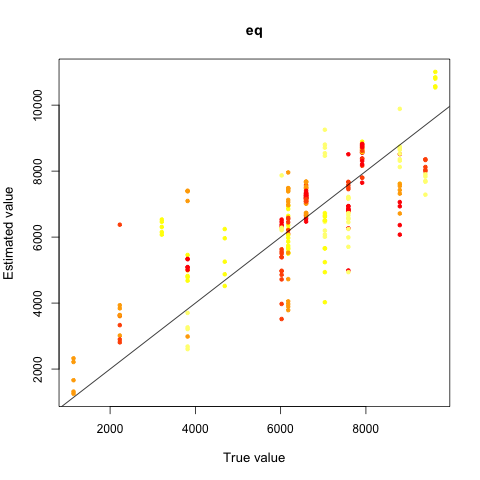

In [74]:
%%R
cv.res.reg <- cv4abc(data.frame(eq=PRIOR[,"K"]), PRIOR[,7:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Call: 
abc(target = OBS, param = data.frame(eq = PRIOR[, "K"]), sumstat = PRIOR[, 
    7:17], tol = 0.005, method = "loclinear")
Data:
 abc.out$adj.values (5678 posterior samples)
Weights:
 abc.out$weights

                               eq
Min.:                    272.0079
Weighted 2.5 % Perc.:   2061.3803
Weighted Median:        4290.1446
Weighted Mean:          4608.8415
Weighted Mode:          3736.8811
Weighted 97.5 % Perc.:  8706.7512
Max.:                  17434.4858
                               eq
Min.:                    272.0079
Weighted 2.5 % Perc.:   2061.3803
Weighted Median:        4290.1446
Weighted Mean:          4608.8415
Weighted Mode:          3736.8811
Weighted 97.5 % Perc.:  8706.7512
Max.:                  17434.4858


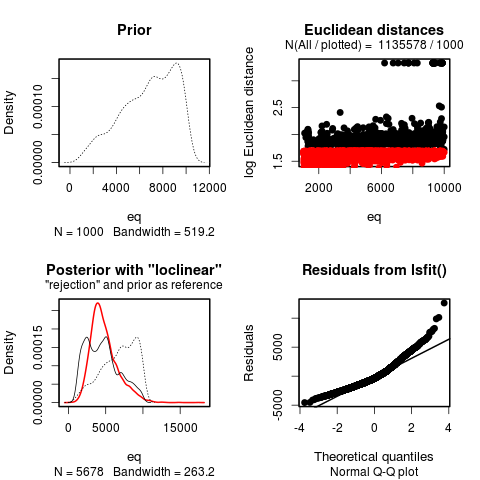

In [134]:
%%R
res.abc = abc(target=OBS, param=data.frame(eq=PRIOR[,"K"]), sumstat=PRIOR[,7:17], tol=0.005, method="loclinear")
print(summary(res.abc))
#hist(res.abc)
plot(res.abc, param=PRIOR[,"K"])

# Co-estimate island size and %equil 

## Estimate island size/%equil using shannon and 1d pi vector

In [ ]:
%%R
cv.res.reg <- cv4abc(data.frame(k=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"]), PRIOR[,8:17], nval=50, tols=c(.001, .005, .01, .05,.1), method="loclinear")
print(summary(cv.res.reg))
plot(cv.res.reg)

Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 
Hit <Return> to see next plot: 


Call: 
abc(target = OBS[2:11], param = data.frame(shan = PRIOR[, "shannon"], 
    eq = PRIOR[, "X.equil"], c = PRIOR[, "colrate"], k = PRIOR[, 
        "K"]), sumstat = PRIOR[, 8:17], tol = 0.002, method = "rejection", 
    hcorr = FALSE)
Data:
 abc.out$unadj.values (800 posterior samples)

                  shan        eq         c         k
Min.:           0.7348    0.0829    0.0001 1015.0000
2.5% Perc.:     1.1431    0.2972    0.0001 4225.0000
Median:         1.8031    0.7035    0.0003 7683.0000
Mean:           1.8413    0.6989    0.0003 7678.7100
Mode:           1.7278    0.6875    0.0002 9537.9955
97.5% Perc.:    2.6151    0.9823    0.0007 9655.0000
Max.:           2.8634    0.9990    0.0019 9855.0000
                     shan           eq            c            k
Min.:        7.348014e-01 8.288410e-02 1.013093e-04 1.015000e+03
2.5% Perc.:  1.143100e+00 2.971733e-01 1.080615e-04 4.225000e+03
Median:      1.803136e+00 7.035196e-01 2.594488e-04 7.683000e+03
Mean:        1.841314e+0

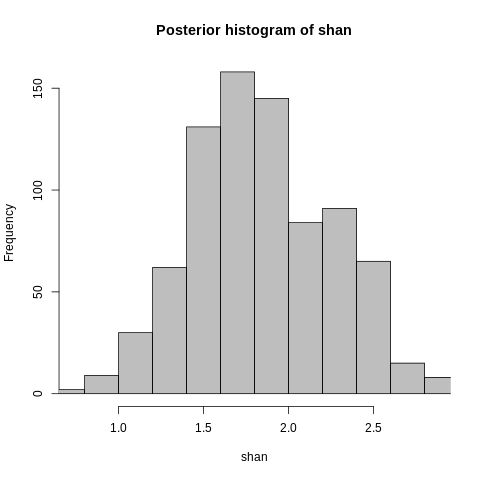

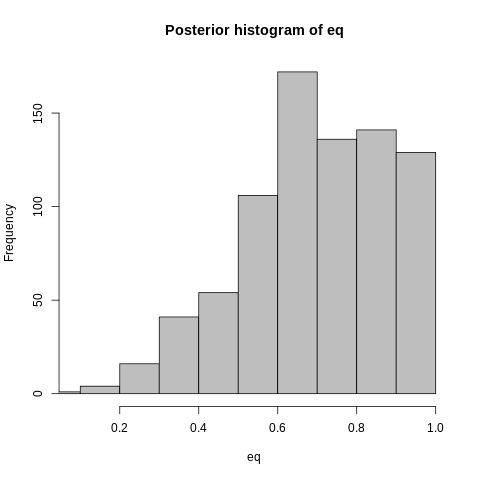

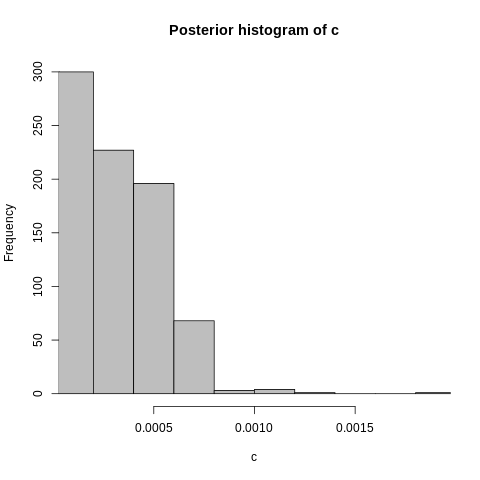

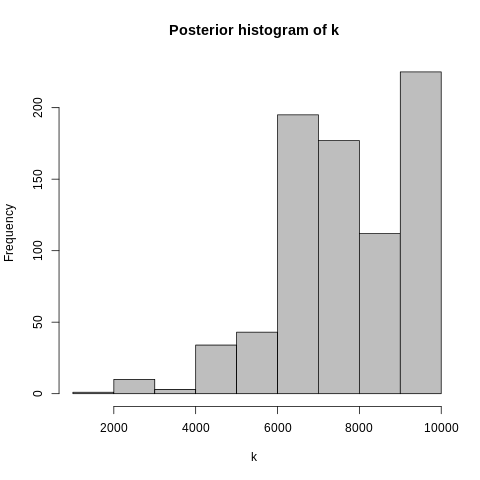

In [146]:
%%R
res.abc = abc(target=OBS[2:11], param=data.frame(shan=PRIOR[,"shannon"], eq=PRIOR[,"X.equil"],
                                                 c=PRIOR[,"colrate"], k=PRIOR[,"K"]), 
                                                 sumstat=PRIOR[,8:17], hcorr=FALSE, tol=0.002, method="rejection")
print(summary(res.abc))
hist(res.abc)

#plot(res.abc, param=data.frame(k=PRIOR[,"K"], eq=PRIOR[,"X.equil"]))

## All crap below here

In [55]:
from collections import Counter

f = open("/home/isaac/gimmeSAD/1d_sims/priors.txt").readlines()
lines = [line.split("\t") for line in f]

c = Counter([])
unif_dat = []
for line in lines:
    try:
        shan_val = line[6][:3]
        if shan_val in c:
            if c[shan_val] > 1000:
                continue
        c.update([shan_val])
        unif_dat.append("\t".join(line))
    except:
        pass
print(c)
with open("/tmp/unifprior.txt", 'w') as outfile:
    outfile.write("\n".join(unif_dat))

Counter({'1.4': 1001, '1.5': 1001, '1.6': 1001, '1.7': 1001, '1.2': 1001, '1.3': 1001, '1.8': 1001, '1.9': 1001, '3.6': 1001, '3.7': 1001, '3.4': 1001, '3.5': 1001, '3.2': 1001, '3.3': 1001, '3.0': 1001, '3.1': 1001, '2.3': 1001, '2.2': 1001, '2.1': 1001, '2.0': 1001, '2.7': 1001, '2.6': 1001, '3.8': 1001, '2.4': 1001, '4.1': 1001, '4.0': 1001, '2.5': 1001, '3.9': 1001, '2.9': 1001, '2.8': 1001, '1.1': 848, '1.0': 690, '0.9': 394, '0.8': 251, '4.2': 199, '0.6': 137, '0.7': 126, '0.5': 61, '-0.': 46, '0.4': 29, '0.3': 13, '0.2': 6, 'sha': 1})


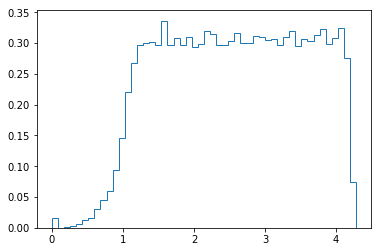

In [64]:
## Get shannon prior
f = open("/home/isaac/gimmeSAD/1d_sims/priors.txt").readlines()
lines = [line.split("\t") for line in f]

shan_dat = []
for line in lines:
    try:
        shan_dat.append(float(line[6]))
    except:
        pass

n, bins, patches = plt.hist(shan_dat, bins=50, histtype="step", normed=True)

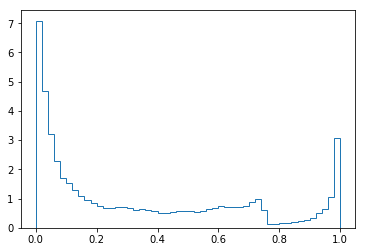

In [87]:
## Get lambda prior
f = open("/home/isaac/gimmeSAD/1d_sims/priors.txt").readlines()
lines = [line.split("\t") for line in f]

lamb_dat = []
for line in lines:
    try:
        lamb_dat.append(float(line[3]))
    except:
        pass

n, bins, patches = plt.hist(lamb_dat, bins=50, histtype="step", normed=True)

In [49]:
from collections import Counter

c = Counter([])
c.update(["1.1"])
if "1.1" in c:
    print("wat")
    print(c["1.1"])
print(c)

wat
1
Counter({'1.1': 1})
